<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
# Section 1: Introduction

The main objective of this notebook is to analyze the whole-brain connectivity of neurons imaged via Light Microscopy (LM). The neurons in this dataset are acquired by imaging the volume of an entire brain wherein a small number of cells are sparsely labelled, and then tracing the axons and dendrites of those cells to reconstruct their full morphologies. Neurons from several brains are integrated by aligning each sample to the Common Coordinate Framework. 



General Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import os
# config.write_default_config()

%matplotlib inline

data_root = "/data/"

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
    
## The Common Coordinate Framework (CCF)

Let's first get familiar with soom tools for interacting with the Common Coordinate Framework (or CCF). We are going to use BrainGlobe to access the Allen Mouse Atlas. BrainGlobe is a software package that facilitates use of different brain atlases to examine anatomical data. You can learn more [here](https://brainglobe.info/about.html).

In the Allen Mouse Atlas, each structure in the brain is identified with a name, an acronym, and an id. We use these to annotate our anatomical data. Being able to reference the atlas helps us to make sense of those annotations.
    
You see more about the CCF [here](https://allenswdb.github.io/background/CCF.html).



Imports for the CCF and BrainGlobe

In [2]:
from brainglobe_atlasapi import BrainGlobeAtlas
import brainglobe_atlasapi as atlasapi
from brainglobe_atlasapi import config

from utils.ccf_utils import get_ccf_property

In [3]:
# Load ccf atlas
brain_globe_path = os.path.join(data_root, ".brainglobe")
atlasapi.config.write_config_value('brainglobe_dir', brain_globe_path)
ccf_atlas = BrainGlobeAtlas('allen_mouse_10um') #here we specify which atlas we want to use

# Print important data structures in "ccf_atlas"
print("This is a look up table which stores basic information about each structure...\n")
print(ccf_atlas.lookup_df)



This is a look up table which stores basic information about each structure...

    acronym   id                                name
0      root  997                                root
1      grey    8       Basic cell groups and regions
2        CH  567                            Cerebrum
3       CTX  688                     Cerebral cortex
4     CTXpl  695                      Cortical plate
..      ...  ...                                 ...
835      V3  129                     third ventricle
836      AQ  140                   cerebral aqueduct
837      V4  145                    fourth ventricle
838     V4r  153                      lateral recess
839       c  164  central canal, spinal cord/medulla

[840 rows x 3 columns]


<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">

The CCF has a hierarchical structure, reflecting the organization of anatomical structures into substructures. To see that hierarchy, uncomment the lines below and run the cell. (The output is very long so we don't run it by default)

In [4]:
# print("\n This is the hierarchy of regions stored in the ccf")
# print(ccf_atlas.structures)

<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We can extract information about a given region in the ccf by querying from `ccf_atlas.structures` using either the ccf id or the acronym of a given structure. </font>
    

In [5]:
ccf_id = 1062
pprint(ccf_atlas.structures[ccf_id])

{'acronym': 'SSp-bfd6b',
 'id': 1062,
 'mesh': None,
 'mesh_filename': PosixPath('/data/.brainglobe/allen_mouse_10um_v1.2/meshes/1062.obj'),
 'name': 'Primary somatosensory area, barrel field, layer 6b',
 'rgb_triplet': [24, 128, 100],
 'structure_id_path': [997, 8, 567, 688, 695, 315, 453, 322, 329, 1062]}


In [6]:
pprint(ccf_atlas.structures['VISp4'])

{'acronym': 'VISp4',
 'id': 721,
 'mesh': None,
 'mesh_filename': PosixPath('/data/.brainglobe/allen_mouse_10um_v1.2/meshes/721.obj'),
 'name': 'Primary visual area, layer 4',
 'rgb_triplet': [8, 133, 140],
 'structure_id_path': [997, 8, 567, 688, 695, 315, 669, 385, 721]}


<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Among the properties of the structure is the "structure_id_path". This shows the full path of the structure within the hierarchy. Notice that the last item in that list is the id of the structure itself. The items before that are the structure's "ancestors". The function `get_structure_ancestors` will print the acronyms of all the ancestors in the specified structure's path.

In [7]:
ccf_atlas.get_structure_ancestors(ccf_id)

['root', 'grey', 'CH', 'CTX', 'CTXpl', 'Isocortex', 'SS', 'SSp', 'SSp-bfd']

<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">

On the other side of the coin, some structures have "descendants" - substructures that are contained within them, and we can access them using `get_structure_descendants`.

In [8]:
ccf_atlas.get_structure_descendants('VISp')

['VISp1', 'VISp2/3', 'VISp4', 'VISp5', 'VISp6a', 'VISp6b']

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Inputs/Outputs of a Single Neuron

Our journey to understand how the brain is connected begins with analyzing how a single neuron connects different regions. We'll begin by choosing a skeleton from our dataset.
    
To start, we need to examine some of the morphological features of a single neuron. We will load the reconstructed <b>skeleton</b>. A precomputed skeleton is a simplified representation of a neuron where its shape is captured by a tree-like structure that passes through the center of the neuron. More specificy, a precomputed skeleton stores a neuron as a graph with vertices and edges in addition to a collection of vertex-attached attributes that capture morphological and anatomical information about the neuron.

    
 Each vertex of the skeleton is an [x,y,z] coordinate. The vertices and their edges form a 'geometric graph'
    
<p> Note: Observe that many attributes such as "radius" and "compartment" have the same shape as "vertices". Each vertex may also be associated with one or more other properties, including:
<ul>
    <li> <code>radius</code>: the estimated cross-section radius of the segment
    <li> <code>compartment</code>: whether the segment belongs to the axon, dendrite, or soma. 
</ul>

<p>We will see these properties rendered later in this notebook, and discuss the other properties synapse properties in later notebooks. 

</div>


<img src="attachment:4b6ade1b-3db3-44bd-9c94-277dc93a20e5.png" width="600">
Image from Kötter, R., Ascoli, G. A., Krichmar, J. L., Nasuto, S. J., & Senft, S. L. (2001)

To look at these neurons, let's import some utility functions for loading and visualizing the skeletons, and then load all of the data in our capsule. This will take a minute.

In [9]:
#imports
from utils.ccf_utils import get_ccf_ids
from utils.skeleton_loading_utils import number_of_samples, load_lm_datasets, progress_bar
import skeleton_plot as skelplot

In [10]:
#load full dataset
skel_list = load_lm_datasets(data_root)

Loading datasets...
exaSPIM_609281_2022-11-03_13-49-18_reconstructions/precomputed:  [==================================================] 25/25
exaSPIM_651324_2023-03-06_15-13-25_reconstructions/precomputed:  [==================================================] 13/13
exaSPIM_653158_2023-06-01_20-41-38_reconstructions/precomputed:  [==================================================] 42/42
exaSPIM_653980_2023-08-10_20-08-29_reconstructions/precomputed:  [==================================================] 21/21
mouselight_reconstructions/precomputed:  [==================================================] 1549/1549


How many total neurons are contained within these datasets?

In [11]:
len(skel_list)

1650

<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We'll begin by looking at one skeleton.

In [12]:
skel = skel_list[56]

<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">

The `vertices` are the positions of each node of the graph

In [13]:
skel.vertices

array([[6143497. , 3803408.8, 6324864. ],
       [6158765. , 3786851.5, 6331207. ],
       [6164758. , 3774748.8, 6330786. ],
       ...,
       [4220296. , 5385288.5, 7220468. ],
       [4226167.5, 5395354.5, 7209050.5],
       [4238044.5, 5408118. , 7193656. ]], dtype=float32)

<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">

The `vertices_properties` provide important information about each vertex, including the CCF id, the compartment, and the radius (though for all our data, the radius does not vary).

In [14]:
skel.vertex_properties

{'ccf': array([362, 362, 362, ...,  56,  56,  56]),
 'compartment': array([1, 3, 3, ..., 2, 2, 2]),
 'radius': array([1., 1., 1., ..., 1., 1., 1.], dtype=float32)}

<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">
       
**Note about morphological compartments:** The compartment types defined at each vertex adhere to standardized conventions for neuronal morphologies saved as swc files (for more information, see here: <a href="www.neuromorpho.org">www.neuromorpho.org</a>). These conventions are as follows:
    
<ul>
<li> 0 - undefined
<li> 1 - soma
<li> 2 - axon
<li> 3 - (basal) dendrite
<li> 4 - apical dendrite
<li> 5+ - custom
</ul>

In most of these neurons, distinctions were not made between basal or apical dendrites - therefore dendrites should almost exclusively map to compartment type "3". 

</div>

<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">

There are other properties we'll look at in the skeleton including the `root` (the vertex that is the soma) as well as `end_points` or `branch_points`. Calling these properties indicates which vertices have those attributes.

In [15]:
skel.root

array(0)

In [16]:
skel.end_points[:20]

array([ 26,  32,  50,  62,  69,  78,  83,  86,  95, 114, 122, 130, 141,
       160, 169, 176, 184, 197, 211, 227])

<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We could start to look at the shape of the skeleton by starting to plot the vertices. Let's plot the first 200 vertices

Text(0, 0.5, 'Y')

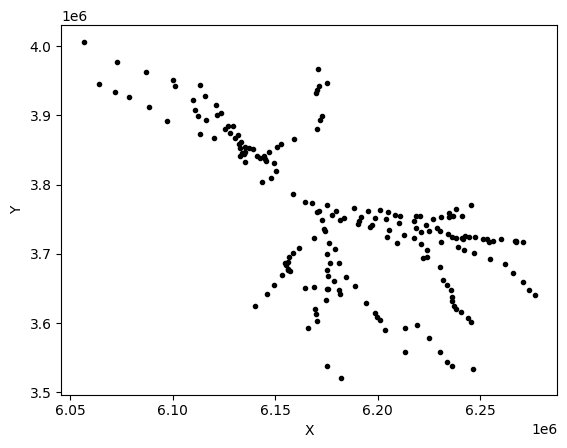

In [17]:
for i in range(200):
    plt.plot(skel.vertices[i,0], skel.vertices[i,1], 'k.')
    
plt.xlabel("X")
plt.ylabel("Y")

<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> With 10,000 vertices, that's not an efficient way to look at these skeletons. Instead, we can use some common tools to visualize the skeleton in both 2D and 3D. First, we'll use `skelplot` to look at it in 2D.
    
Key things we're going to specify is which skeleton to plot, which colors to use for the different compartments, and which two axes to use. Here we'll plot x and y.
</div>

(2715245.25, 6291975.0, 6244127.5, 2641605.75)

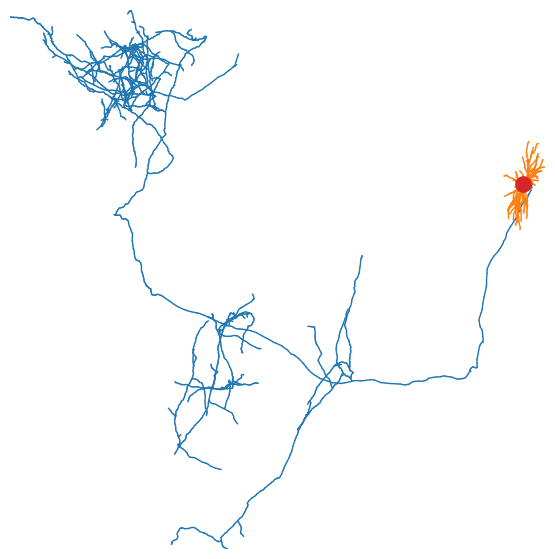

In [18]:
f, ax = plt.subplots(figsize=(7, 7))

skelplot.plot_tools.plot_skel(
    skel,
    line_width=1,
    plot_soma=True,
    invert_y=True,
    pull_compartment_colors=True,
    skel_color_map={0: "tab:green", 1: "tab:red", 2: "tab:blue", 3: "tab:orange"},
    x="x",
    y="y",
)

ax.spines['right'].set_visible(False) 
ax.spines['left'].set_visible(False) 
ax.spines['top'].set_visible(False) 
ax.spines['bottom'].set_visible(False)
ax.axis('off')    

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<font size="4"> <p>Can you use skelplot to plot x vs z instead? Copy and paste the code from above and make modifications:
</div>

<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<p> Now let's look at this neuron in 3 dimensions. First, we'll define some plotting functions. You don't need to understand these.
    
The cell below creates the plot, adding the skeleton as well as a mesh of the entire mouse brain, and the CCF region where this one skeleton's soma is located. You can zoom and spin to examine this in more detail.
</div>

In [19]:
# Imports
import k3d
import random
import trimesh
import os

# Define plotting functions to turn a skeleton into line objects
def plot_graphs(graphs, plot, color = None, opacity = 1):
    for i, g in enumerate(graphs):
        if color == None:
            colorstr = "%06x" % random.randint(0, 0xFFFFFF)
            c  = int(colorstr, 16) + 0x200
        elif type(color) == type([]):
            c = color[i]
        else:
            c = color
        plot += graph_to_lines(g,c,opacity)
        
def graph_to_lines(g, color=None, opacity = 1):
    lines = k3d.factory.lines(
        g.vertices,
        g.edges,
        indices_type='segment', 
        width=1, shader='simple',
        color=color,
        opacity=opacity
    )
    return lines

def get_whole_ccf_mesh():
    ''' Gets the mesh of the whole mouse brain '''
    
    mesh_path = os.path.join(data_root, "AllenCCFMesh", "MouseBrainAllen3.obj")
    with open(mesh_path) as f:
        return trimesh.load(f, 'obj')

def get_region_ccf_mesh(ccf_id):
    ''' Gets the mesh of a specific brain region '''
    
    mesh_path = get_ccf_property(ccf_atlas, ccf_id, "mesh_filename")
    try:
        with open(mesh_path) as f:
            return trimesh.load(f, 'obj')
    except:
        print("Mesh does not exist!")


In [20]:
# Generate plot
plot = k3d.plot()

#plot the specified skeleton
plot_graphs([skel], plot)

# Add whole ccf mesh
ccf_mesh = get_whole_ccf_mesh()
mesh_plot = k3d.mesh(ccf_mesh.vertices*1000, ccf_mesh.faces, opacity=0.2, color=808080)
plot += mesh_plot

# Add mesh of the ccf region of the soma
soma_ccf_id = get_ccf_ids(ccf_atlas, skel, compartment_type=1)[0]
region_mesh = get_region_ccf_mesh(soma_ccf_id)
region_mesh_plot = k3d.mesh(region_mesh.vertices*1000, region_mesh.faces, opacity=0.2)
plot += region_mesh_plot

plot.display()

Output()

<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Now that we've visualized the neuron, let's see what we can learn about its inputs and outputs. We can use the skeleton to look at the ccf locations of the different parts of the cell. 
We will use a convenience function we've provided called `get_ccf_ids`. This function allows us to specify the compartment type and the vertex properties (e.g. branch point, end point) to find the CCF id for specific types of vertices.</p>
 
    
<p>Let's start by looking at the location of the soma
</div>

In [21]:
soma_ccf = get_ccf_ids(ccf_atlas, skel, compartment_type=1) 
pprint(ccf_atlas.structures[soma_ccf[0]])

{'acronym': 'MD',
 'id': 362,
 'mesh': None,
 'mesh_filename': PosixPath('/data/.brainglobe/allen_mouse_10um_v1.2/meshes/362.obj'),
 'name': 'Mediodorsal nucleus of thalamus',
 'rgb_triplet': [255, 144, 159],
 'structure_id_path': [997, 8, 343, 1129, 549, 856, 444, 362]}


<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Now let's find the dendritic end_points. We need to specify the compartment_type (see table above) and the vertex_type
</div>

In [22]:
dendrite_endpoints_ccf = get_ccf_ids(ccf_atlas, skel, compartment_type=3, vertex_type="end_points")

<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">
How many endpoints are there?
</div>

In [23]:
len(dendrite_endpoints_ccf)

55

<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Where are the unique structures where these endpoints are located?
</div>

In [24]:
for ccfid in np.unique(dendrite_endpoints_ccf): #For each unique id in the list of endpoints 
    if ccfid>0:
        #count the number of endpoints with that id
        #print the result
        print(str(len(np.where(dendrite_endpoints_ccf==ccfid)[0])) + " dendrite endpoints in " + ccf_atlas.structures[ccfid]["name"])

13 dendrite endpoints in Anterodorsal nucleus
2 dendrite endpoints in Anteroventral nucleus of thalamus
22 dendrite endpoints in Mediodorsal nucleus of thalamus
3 dendrite endpoints in stria medullaris
15 dendrite endpoints in Interanterodorsal nucleus of the thalamus


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<font size="4"> <p>Find the unique structures for the axon endpoints.
</div>

In [25]:
axon_endpoints_ccf = 

<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Let's make a bar plot of these locations, sorting the results. 
</div>

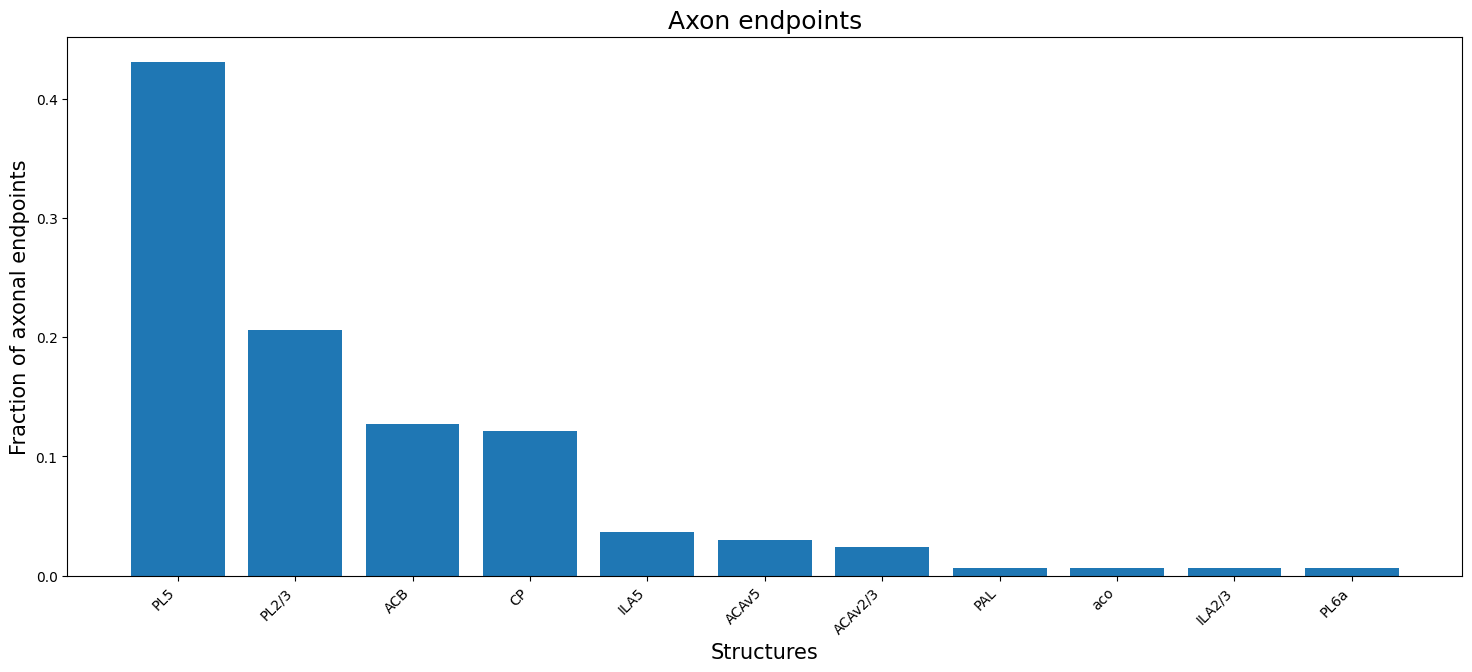

In [26]:
#get the counts of endpoints for each unique location
ids, cnts = np.unique(axon_endpoints_ccf, return_counts=True)

#sort the resutls based on count, and order from largest to smallest
cnts_sort = cnts[np.argsort(cnts)[::-1]]
ids_sort = ids[np.argsort(cnts)[::-1]]

# Get brain region names
ccf_names = list()
for ccf_id in ids_sort:
    if ccf_id>0:
        acronym = ccf_atlas.structures[ccf_id]['acronym']
        ccf_names.append(acronym)
    else:
        ccf_names.append('NaN')
    
# Make plot
plt.figure(figsize=(18, 7))
#plot the number of endpoints, normalized to total number of endpoints
plt.bar(ccf_names, cnts_sort/cnts_sort.sum())

# Add titles and labels
plt.xticks(rotation=45, ha='right')
plt.title("Axon endpoints", fontsize=18)
plt.xlabel("Structures", fontsize=15)
plt.ylabel("Fraction of axonal endpoints", fontsize=15)

# Show the plot
plt.show()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">
<font size="4"> <p>What is the name of the structure with the most endpoints?
</div>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Where are our skeleton somas located

We have 1650 skeletons loaded in this capsule. Let's see where these are located in the brain. 
To do this, we'll need to vertex location of the soma of each skeleton.


</div>

In [27]:
skel.vertices[0]

array([6143497. , 3803408.8, 6324864. ], dtype=float32)

In [28]:
somas = []
for i in range(len(skel_list)): #iterate across all skeletons
    skel = skel_list[i]
    somas.append(skel.vertices[skel.root]) #find the vertex of the root. Add to our list of soma locations
    # try:
        # soma_ids.append(ccf_atlas.structures[skel.vertex_properties['ccf'][0]]['id'])
    # except:
        # print(i)

<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Let's plot this along with a mesh of the entire mouse brain. To do this we'll generate a 3D plot similar to the one above, but instead of adding a skeleton, we'll add a point for each soma.
</div>

In [29]:
# Generate plot
plot = k3d.plot()

#plot each soma location
points = k3d.points(positions=np.array(somas),
                        point_size=100000,
                        shader='3d',
                        color=0xcc0000)
plot += points

# Add whole ccf mesh
ccf_mesh = get_whole_ccf_mesh()
mesh_plot = k3d.mesh(ccf_mesh.vertices*1000, ccf_mesh.faces, opacity=0.2, color=808080)
plot += mesh_plot


plot.display()

Output()

<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Why are there more somas in certain regions?
    
Let's add meshes for some key brain structures: TH, MOs, HPF. 
What are these structures?
</div>

In [30]:
# Generate plot
plot = k3d.plot()

#plot each soma location
points = k3d.points(positions=np.array(somas),
                        point_size=100000,
                        shader='3d',
                        color=0xcc0000)
plot += points

# Add whole ccf mesh
ccf_mesh = get_whole_ccf_mesh()
mesh_plot = k3d.mesh(ccf_mesh.vertices*1000, ccf_mesh.faces, opacity=0.2, color=808080)
plot += mesh_plot

# Add region of ccf mesh
region_id = ccf_atlas.structures['TH']['id']
region_mesh = get_region_ccf_mesh(region_id)
region_mesh_plot = k3d.mesh(region_mesh.vertices*1000, region_mesh.faces, opacity=0.2)
plot += region_mesh_plot

# Add region of ccf mesh
region_id = ccf_atlas.structures['MOs']['id']
region_mesh = get_region_ccf_mesh(region_id)
region_mesh_plot = k3d.mesh(region_mesh.vertices*1000, region_mesh.faces, opacity=0.3, color=0Xf5c3bf)
plot += region_mesh_plot

# Add region of ccf mesh
region_id = ccf_atlas.structures['RHP']['id']
region_mesh = get_region_ccf_mesh(region_id)
region_mesh_plot = k3d.mesh(region_mesh.vertices*1000, region_mesh.faces, opacity=0.3, color=0Xffe599)
plot += region_mesh_plot

plot.display()

Output()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Diversity of outputs from the same structure
    
Let's look at one structure - in this case a specific nucleus in the thalamus. How similar are the projection patterns of neurons from this structure? 

First, let's find all the neurons with soma in the nucleus, and look at the total outputs (axons endpoints) of all of these neurons.
We'll look at a nucelus in the thalamus called "VAL" - the Ventral anterior-lateral complex of the thalamus.

</div>

In [31]:
pprint(ccf_atlas.structures['VAL'])
target_ccf_id = ccf_atlas.structures['VAL']['id']

{'acronym': 'VAL',
 'id': 629,
 'mesh': None,
 'mesh_filename': PosixPath('/data/.brainglobe/allen_mouse_10um_v1.2/meshes/629.obj'),
 'name': 'Ventral anterior-lateral complex of the thalamus',
 'rgb_triplet': [255, 128, 132],
 'structure_id_path': [997, 8, 343, 1129, 549, 864, 637, 629]}


<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Find all the skeletons with somas in this structure
</div>

In [32]:
skels_subset = []
for i, skel in enumerate(skel_list): #iterate through all the skeltons
    progress_bar(i + 1, len(skel_list)) #visualize progress
    if target_ccf_id in set(get_ccf_ids(ccf_atlas, skel, compartment_type=1)): #is the ccf id of the soma that of our target structure
        skels_subset.append(skel)

print("\n# Skeletons Found:", len(skels_subset))

[==================================================] 1650/1650
# Skeletons Found: 45


<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">
We can get the axon endpoints for each of these neurons and add them to a list, and then count the number of total endpoints for each unique ccf structure, similar to how we did it for our single neuron above. We'll limit our plot to the top 15 structures.
</div>

In [33]:
axon_endpoints_ccf = []
for skel in skels_subset:
    axon_endpoints_ccf.extend(get_ccf_ids(ccf_atlas, skel, compartment_type=2, vertex_type="end_points"))


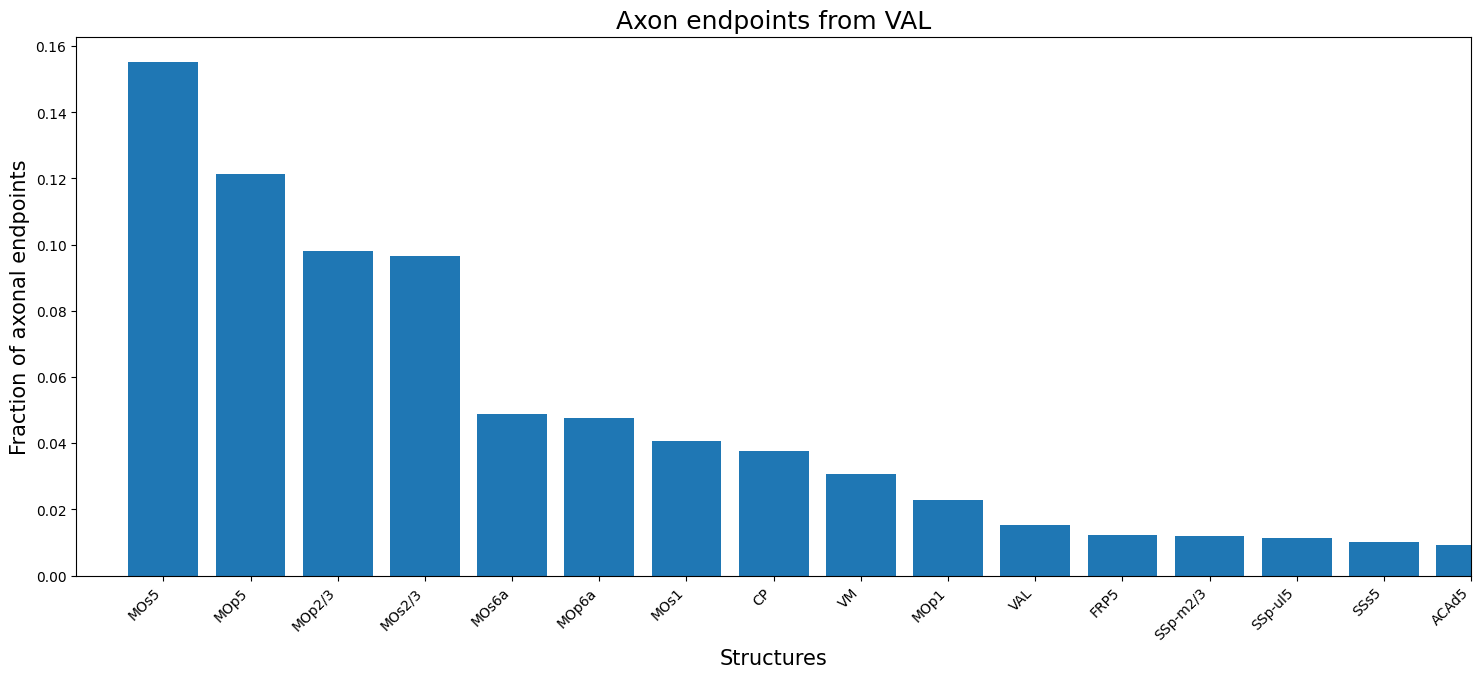

In [34]:
#get the counts of endpoints for each unique location
ids, cnts = np.unique(axon_endpoints_ccf, return_counts=True)

#sort the results based on count, and order from largest to smallest
cnts_sort = cnts[np.argsort(cnts)[::-1]]
ids_sort = ids[np.argsort(cnts)[::-1]]

# Get brain region names
ccf_names = list()
for ccf_id in ids_sort:
    if ccf_id>0:
        acronym = ccf_atlas.structures[ccf_id]['acronym']
        ccf_names.append(acronym)
    else:
        ccf_names.append('NaN')
    
# Make plot
plt.figure(figsize=(18, 7))
#plot the number of endpoints, normalized to total number of endpoints
plt.bar(ccf_names, cnts_sort/cnts_sort.sum())

#limit plot to the top 15 structures
plt.xlim(-1,15)

# Add titles and labels
plt.xticks(rotation=45, ha='right')
plt.title("Axon endpoints from VAL", fontsize=18)
plt.xlabel("Structures", fontsize=15)
plt.ylabel("Fraction of axonal endpoints", fontsize=15)



# Show the plot
plt.show()

<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Now let's pick two neurons from this subset to compare. We'll compare the 3rd and the 44th neurons.
</div>

In [35]:
skel_a = skels_subset[3]
ccf_a = get_ccf_ids(ccf_atlas, skel_a, compartment_type=2, vertex_type="end_points")

skel_b = skels_subset[44]
ccf_b = get_ccf_ids(ccf_atlas, skel_b, compartment_type=2, vertex_type="end_points")


<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Count the number of endpoints for each neuron for the ccf structures identified for the total VAL outputs
</div>

In [36]:
a_cnt = []
b_cnt = []
for cid in ids_sort:
    a_cnt.append(len(np.where(ccf_a==cid)[0])/len(ccf_a)) #find number of endpoints in that ccf region, normalize)
    b_cnt.append(len(np.where(ccf_b==cid)[0])/len(ccf_b)) #find number of endpoints in that ccf region, normalize)
    
    

<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">
Plot the fraction on endpoints for these two neurons next to the total output of VAL
</div>

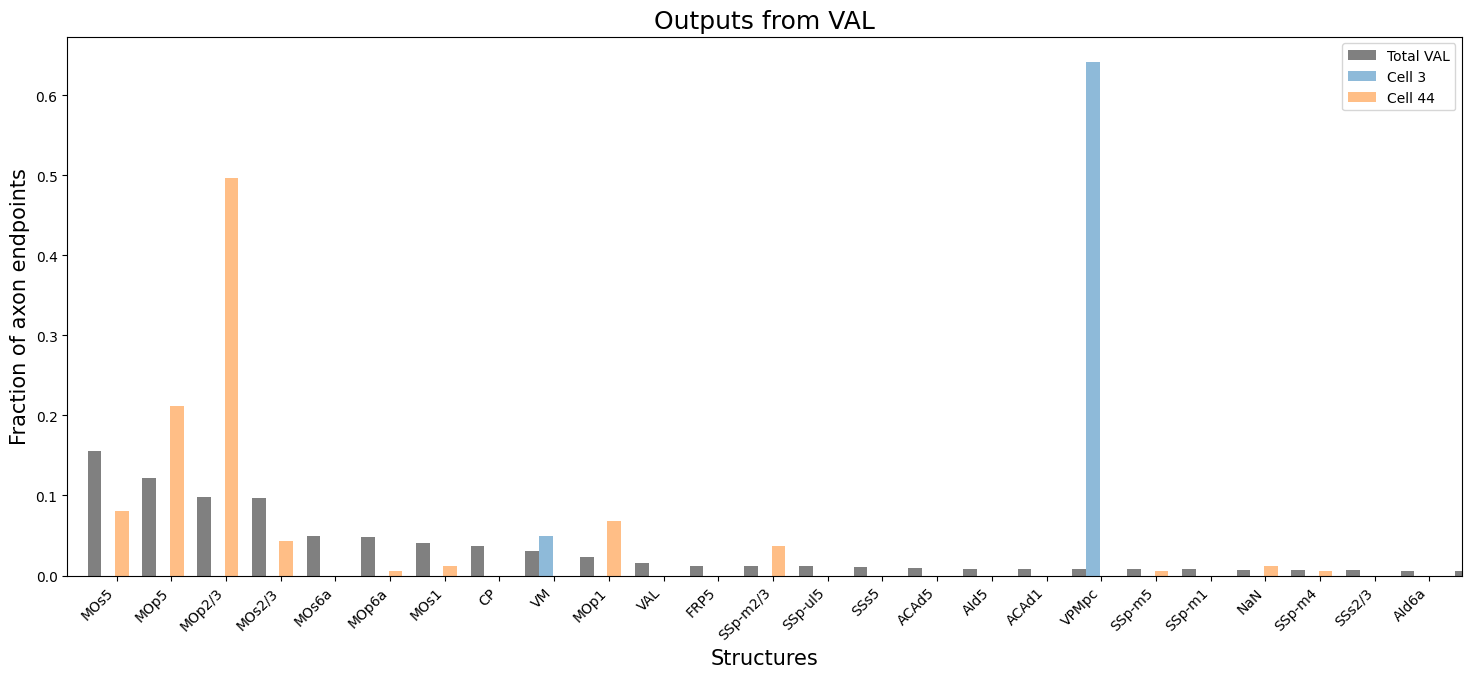

In [37]:
plt.figure(figsize=(18, 7))

#x positions
x = np.arange(len(ccf_names))

#plot the total output of VAL
plt.bar(x, cnts_sort/cnts_sort.sum(), width=0.25, color='gray', label="Total VAL")

#plot the output of cell 3
plt.bar(x+0.25, a_cnt, width=0.25, alpha=0.5, label="Cell 3")
plt.bar(x+0.5, b_cnt, width=0.25, alpha=0.5, label="Cell 44")

#labels and ticks
plt.xticks(x+0.4, ccf_names, rotation=45, ha='right');
plt.xlim(-0.5,25)
plt.title("Outputs from VAL", fontsize=18)
plt.ylabel("Fraction of axon endpoints", fontsize=15)
plt.xlabel("Structures", fontsize=15)
plt.legend()

<div style="padding: 1px; padding-left: 10px; background: #F0FAFF; ">
We can visualize these two neurons using the plotting logic we used above, looking at them in 3D.
</div>

In [38]:
# Generate plot
plot = k3d.plot()

#plot the specified skeleton
plot_graphs([skels_subset[3]], plot)
plot_graphs([skels_subset[44]], plot)

# Add whole ccf mesh
ccf_mesh = get_whole_ccf_mesh()
mesh_plot = k3d.mesh(ccf_mesh.vertices*1000, ccf_mesh.faces, opacity=0.2, color=808080)
plot += mesh_plot

# Add mesh of the ccf region of the soma
soma_ccf_id = get_ccf_ids(ccf_atlas, skels_subset[3], compartment_type=1)[0]
region_mesh = get_region_ccf_mesh(soma_ccf_id)
region_mesh_plot = k3d.mesh(region_mesh.vertices*1000, region_mesh.faces, opacity=0.2)
plot += region_mesh_plot

plot.display()

Output()